# Link To Paper
# First Author: Henry Ndubuaku
# Supervisor: Prof Matthew Purver
# 2nd Supervisor: Dr. Ravi Sherkhar
https://drive.google.com/file/d/1OnKuNsiiasiN6TcL6bMvldQajZF04rj4/view?usp=sharing

Please glance through to understand the code

# Data (Run)

In [ ]:
%%capture
!pip install rake-nltk
!pip install tensorflow_text
!pip install bert-score
!pip install datasets

In [ ]:
########################################### LOAD DATA ######################################
import numpy as np
import tensorflow_text
from keras.preprocessing.sequence import pad_sequences

# Set variables
maxlen = 30
vocab_size = 9832

# Load Data
jokes = np.load("encoded_jokes.npy", allow_pickle=True)

# Create tokenizer from saved vocab file
tokenizer = tensorflow_text.BertTokenizer('vocab.txt', **dict(lower_case=True))

# Copy the first 30 tokens of each joke as the source
source = jokes[:, :-1]
# Insert the start token at the begining of each
source = np.insert(source[:,:-1], 0, 2, axis=1)

# For a reconstruction seq2seq, the source and target is the same
target = source

# Isolate the next token at each time step as labels
labels = np.expand_dims(target[:, 1:],axis=2)

# Zero-pad labels
labels = pad_sequences(labels,
                       value=0,
                       padding='post',
                       maxlen=30)

In [ ]:
################################### EXTRACT KEYWORDS #################################
import numpy as np
import tensorflow as tf
from rake_nltk import Rake
# Tokenize jokes
tokenized_jokes = tokenizer.detokenize(jokes)
tokenized_jokes = list(tokenized_jokes.numpy())
data = []

# Convert jokes to string
for x in tokenized_jokes:
  x = [y.decode("utf-8") for y in x]
  x = " ".join([y for y in x if y != '[PAD]'])
  data.append(x)


# Extract keywords
r = Rake(max_length=1)
kws = []

for x in data:
  kw = r.extract_keywords_from_text(x)
  kw = r.get_ranked_phrases()
  kws.append(kw)


# Tokenize and encode keywords
keywords_int = tf.ragged.constant(kws)
keywords_int = tokenizer.tokenize(keywords_int)
# Reshape
keywords_int = keywords_int.merge_dims(-2,-1).to_list()

# Squeeze list
keywords = []
for x in keywords_int:
  x = [item for sublist in x for item in sublist]
  keywords.append(x)

# Pad sequences
keywords = tf.keras.preprocessing.sequence.pad_sequences(keywords,
                                            value=0,
                                            padding='post',
                                            maxlen=maxlen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/ragged/ragged_tensor.py:2053: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(rows)


In [ ]:
######################################## SPLIT INTO TRAIN AND TEST ##########################
idx = int(0.2 * len(source))
test_seq = source[:idx]
test_keywords = keywords[:idx]

source = source[idx:]
keywords = keywords[idx:]
target = target[idx:]
labels = labels [idx:]

# Utils (Run)

In [ ]:
########################## SEQUENCE RECONSTRUCTION ALGORITHM #######################
import numpy as np
import tensorflow as tf

def reconstruct(seq, kw, encoder, stepper, decoder, tokenizer, start=[2], top_k=1):
    # Obtain the latent variable
    e_h = encoder.predict(seq)
    
    # Use stepper to obtain the encoder outputs and cell state
    e_out, e_c = stepper.predict([e_h, kw])

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the index of start token.
    for i in range(len(start)):
      target_seq[i, i] = start[i]

    stop_condition = False
    decoded_sentence = ''

    # Generate using top_k sampling
    while not stop_condition:
        (output_tokens, h, c) = decoder.predict([target_seq]
                + [e_out, e_h, e_c])

        # Get probabilities from the last sequence
        probs = output_tokens[0, -1, :]
        # Select top_k probabilities and convert to array
        preds = tf.math.top_k(probs, k=top_k, sorted=True)
        preds = np.array(preds)
        # Get equivalent probabilities for the top_k probabilities
        score = preds[0] / sum(preds[0])
        # Convert indicies to array and probalistically select a choice
        preds = np.asarray(preds[1]).astype("int32")
        sampled_token_index = np.random.choice(preds, p=score)

        # Detokenize indices
        sampled_token = tokenizer.detokenize([[sampled_token_index]]).to_list()
        sampled_token = sampled_token[0][0].decode("utf-8")

        if sampled_token != '[PAD]':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '[PAD]' or len(decoded_sentence.split()) \
            >= maxlen - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence.replace(" ##",'')

In [ ]:
############################ DETOKENIZE FUNCTION #######################
def detokenize(indices, tokenizer):
  word_tokens = tokenizer.detokenize([indices]).to_list()
  word_tokens = [x.decode("utf-8") for x in word_tokens[0]]
  return word_tokens
  return " ".join([x for x in word_tokens if x != '[PAD]'])

In [ ]:
######################## WASSERSTEIN GRADIENT PENALTY ###################
import torch
import torch.autograd as autograd

def compute_grad_penalty(critic, real_data, fake_data):
    B = real_data.size(0)
    alpha = torch.FloatTensor(np.random.random((B, 1)))
    if cuda:
        alpha = alpha.cuda()
    sample = alpha*real_data + (1-alpha)*fake_data
    sample.requires_grad_(True)
    score = critic(sample)

    outputs = torch.FloatTensor(B, latent_dim).fill_(1.0)
    outputs.requires_grad_(False)
    if cuda:
        outputs = outputs.cuda()
    grads = autograd.grad(
        outputs=score,
        inputs=sample,
        grad_outputs=outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()
    return grad_penalty

In [ ]:
############################## GAN TRAINING ALGORITHM ############################
def train_gan(epoch):
    generator.train()
    critic.train()
    c_train_loss = 0.
    g_train_loss = 0.
    g_batches = 0
    for i, x in enumerate(train_loader):
        if cuda:
            x = x.cuda()
        
        # train critic
        B = x.size(0)
        c_optimizer.zero_grad()
        noise = torch.from_numpy(np.random.normal(0, 1, (B, latent_dim))).float()
        if cuda:
            noise = noise.cuda()
        with torch.no_grad():
            x = x.cpu()
            x = x.numpy()
            z_real = encoder(x)
            z_real = z_real.numpy()
            z_real = torch.FloatTensor(z_real).cuda()

        z_fake = generator(noise)
        real_score = critic(z_real)
        fake_score = critic(z_fake)
        grad_penalty = compute_grad_penalty(critic, z_real.data, z_fake.data)
        c_loss = -torch.mean(real_score) + torch.mean(fake_score) + gp_lambda*grad_penalty
        c_train_loss += c_loss.item()
        c_loss.backward()
        c_optimizer.step()

        # train generator
        if i % n_critic == 0:
            g_batches += 1
            g_optimizer.zero_grad()
            fake_score = critic(generator(noise))
            g_loss = -torch.mean(fake_score)
            g_train_loss += g_loss.item()
            g_loss.backward()
            g_optimizer.step()
        #'''
        if interval > 0 and i % interval == 0:
            print('Epoch: {} | Batch: {}/{} ({:.0f}%) | G Loss: {:.6f} | C Loss: {:.6f}'.format(
                epoch, batch_size*i, len(train_loader.dataset),
                100.*(batch_size*i)/len(train_loader.dataset),
                g_loss.item(), c_loss.item()
            ))
        #'''
    g_train_loss /= g_batches
    c_train_loss /= len(train_loader)
    print('* (Train) Epoch: {} | G Loss: {:.4f} | C Loss: {:.4f}'.format(
        epoch, g_train_loss, c_train_loss
    ))
    return (g_train_loss, c_train_loss)

In [ ]:
################################# GENERATION ALGORITHM #############################
import numpy as np
import torch

def generate_joke(kw, generator, stepper, decoder, tokenizer, start=[2], latent_dim=100, top_k=1):
    # Obtain the latent variable from a random noise
    noise = torch.from_numpy(np.random.normal(0, 1, (1, latent_dim))).float()
    z = generator(noise[None,:,:])
    z = z.squeeze(dim=1)
    z = z.cpu()
    e_h = z.detach().numpy()
    
    # Use stepper to obtain the encoder outputs and cell state
    (e_out, e_c) = stepper.predict([e_h, kw])

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the index of start token.
    for i in range(len(start)):
      target_seq[i, i] = start[i]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder.predict([target_seq]
                + [e_out, e_h, e_c])
        
        '''
        # Top K Sampling
        # Get probabilities from the last sequence
        probs = output_tokens[0, -1, :]
        # Select top_k probabilities and convert to array
        preds = tf.math.top_k(probs, k=top_k, sorted=True)
        preds = np.array(preds)
        # Get equivalent probabilities for the top_k probabilities
        score = preds[0] / sum(preds[0])
        # Convert indicies to array and probalistically select a choice
        preds = np.asarray(preds[1]).astype("int32")
        sampled_token_index = np.random.choice(preds, p=score)

        # Detokenize indices
        '''

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tokenizer.detokenize([[sampled_token_index]]).to_list()
        sampled_token = sampled_token[0][0].decode("utf-8")

        if sampled_token != '[PAD]':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '[PAD]' or len(decoded_sentence.split()) \
            >= maxlen - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence.replace(" ##",'')

In [ ]:
def decoder_decode(topic, encoder_model, decoder_model, tokenizer, start=[2], hidden_dim=100, top_k=1):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(topic)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the index of start token.
    for i in range(len(start)):
      target_seq[i, i] = start[i]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])
       
        # Top-k Sampling
        # Get probabilities from the last sequence
        probs = output_tokens[0, -1, :]
        # Select top_k probabilities and convert to array
        preds = tf.math.top_k(probs, k=top_k, sorted=True)
        preds = np.array(preds)
        # Get equivalent probabilities for the top_k probabilities
        score = preds[0] / sum(preds[0])
        # Convert indicies to array and probalistically select a choice
        preds = np.asarray(preds[1]).astype("int32")
        sampled_token_index = np.random.choice(preds, p=score)
        
        sampled_token = tokenizer.detokenize([[sampled_token_index]]).to_list()
        sampled_token = sampled_token[0][0].decode("utf-8")

        if sampled_token != '[PAD]':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '[PAD]' or len(decoded_sentence.split()) \
            >= maxlen - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence.replace(" ##",'')

# Load models
def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = keras.models.model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

# Models (Run)

In [ ]:
from keras.layers import Layer
######################################## SAMPLING LAYER ####################################
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


#################################### VAE LOSS ##############################
def vae_loss(y_true, y_pred):
    xent_loss = sparse_categorical_crossentropy(y_true, y_pred)
    kl_loss =  -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    return xent_loss + kl_loss

In [ ]:
###################################### LUONG ATTENTION LAYER #############################
import numpy as np
import tensorflow.keras.backend as K
from keras.layers import Layer

class LuongAttentionLayer(Layer):
  def compute_mask(self, inputs, mask=None):
    if mask == None:
      return None
    return mask[1]

  def compute_output_shape(self, input_shape):
    return (input_shape[1][0],input_shape[1][1],input_shape[1][2]*2)


  def call(self, inputs, mask=None):
    encoder_outputs, decoder_outputs = inputs

    # transpose the dimensions of decoder outputs
    decoder_outputs_t = K.permute_dimensions(decoder_outputs, (0,2,1))

    # calculate luong score
    luong_score = K.batch_dot(encoder_outputs,decoder_outputs_t)
    luong_score = K.softmax(luong_score, axis=1) # along the 2nd axis

    # expand the dimensions of luong score and encoded outputs to enable multiplication
    luong_score = K.expand_dims(luong_score, axis=-1) # along last axis
    encoder_outputs = K.expand_dims(encoder_outputs, axis=2) # along 2nd axis

    # get encoded vector
    encoder_vector = encoder_outputs * luong_score
    encoder_vector = K.sum(encoder_vector, axis=1, keepdims=False)

    # [batch,max_dec,2*emb]
    new_decoder_outputs = K.concatenate([decoder_outputs, encoder_vector])

    return new_decoder_outputs

In [ ]:
####################################### GPT-3 STYLE TRANSFORMER ####################################
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Layer, LayerNormalization, MultiHeadAttention, Dropout

def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

class TransformerBlock(Layer):
    def __init__(self, embed_dim=100, num_heads=3, ff_dim=100, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = Sequential(t
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
#################################### SEQ2SEQ ##################################
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, RepeatVector
from keras.layers import Bidirectional, LayerNormalization, GlobalAveragePooling1D, Concatenate

def r_seq2seq(latent_dim = 100, embedding_dim = 200, r_drop = 0.0, d_drop = 0.4, 
            weights=False, maxlen=30, kw_len=10, vocab_size=9832):
            
  # Divide latent dim for Bidirectional
  latent_dim_0 = int(latent_dim / 2)

  ################################# TRAIN ENCODER ##################################
  # Source input
  encoder_inputs = Input(shape=(maxlen, ))

  # Embedding layer
  enc_emb_layer = Embedding(vocab_size, embedding_dim, trainable=True)
  enc_emb = enc_emb_layer(encoder_inputs)

  # Encoder BiLSTM
  encoder_bilstm = Bidirectional(LSTM(latent_dim_0,
                                      dropout=d_drop,
                                      recurrent_dropout=r_drop))
  
  hidden = encoder_bilstm(enc_emb)


  ################################# TRAIN STEPPER #####################################
  # Keyword input
  keyword_inputs = Input(shape=(maxlen, ))

  # Keyword embedding
  keyword_emb_layer = Embedding(vocab_size, latent_dim, trainable=True)
  keyword_emb = keyword_emb_layer(keyword_inputs)

  # Keyword Dense
  keyword_dense_layer = Dense(latent_dim)
  keyword_dense = keyword_dense_layer(keyword_emb)


  # Repeat and rewight hidden variable
  hidden_outputs = RepeatVector(maxlen)(hidden)
  hidden_dense_layer = Dense(latent_dim)
  hidden_dense = hidden_dense_layer(hidden_outputs)

  # Add hidden layer and keywords
  stepper_outputs = hidden_dense + keyword_dense

  # Normalise
  layer_norm_1 = LayerNormalization()
  stepper_outputs = layer_norm_1(stepper_outputs)

  # Cell
  cell = GlobalAveragePooling1D()(keyword_emb)
  cell = cell + hidden
  


  ################################# TRAIN DECODER #####################################
  # Target inputs
  decoder_inputs = Input(shape=(None, ))

  # Embedding layer
  dec_emb_layer = Embedding(vocab_size, latent_dim, trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  # Decoder LSTM
  decoder_lstm = LSTM(latent_dim,
                    return_sequences=True,
                    return_state=True,
                    dropout=d_drop,
                    recurrent_dropout=r_drop)
  (decoder_outputs, h, c) = decoder_lstm(dec_emb, initial_state=[hidden, cell])

  # Decoder Layer Norm
  layer_norm_2 = LayerNormalization()
  decoder_outputs = layer_norm_2(decoder_outputs)

  # Stepper-Decoder Luong Attention
  decoder_attention = LuongAttentionLayer( )
  decoder_outputs = decoder_attention([stepper_outputs,decoder_outputs])
  
  # Final Dense layer
  decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model
  model = Model([encoder_inputs, keyword_inputs, decoder_inputs], decoder_outputs, name='Train_Model')

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

  # Load weights if available
  if weights:
    model.load_weights(weights)


  ############################# INFERENCE ENCODER ##########################
  encoder = Model(inputs=encoder_inputs, outputs=hidden, name='Encoder')


  ############################# INFERENCE STEPPER ##########################
  input_z = Input(shape=(latent_dim, ))

  # Embed and reweight keyword
  keyword_emb_s = keyword_emb_layer(keyword_inputs)
  keyword_dense_s = keyword_dense_layer(keyword_emb_s)

  # Repeat and reweight hidden variable
  hidden_outputs_s = RepeatVector(maxlen)(input_z)
  hidden_dense_s = hidden_dense_layer(hidden_outputs_s)

  # Add and normalise
  outputs_s = hidden_dense_s + keyword_dense_s
  outputs_s = layer_norm_1(outputs_s)

  # Cell
  cell_s = GlobalAveragePooling1D()(keyword_emb_s)
  cell_s = cell_s + input_z

  # Build Model
  stepper = Model(inputs=[input_z, keyword_inputs], outputs=[outputs_s, cell_s], name='Stepper')


  ############################ INFERENCE DECODER ############################
  # Below tensors will hold the states of the previous time step
  input_h = Input(shape=(latent_dim, ))
  input_c = Input(shape=(latent_dim, ))
  input_s = Input(shape=(maxlen, latent_dim))

  # Get the embeddings of the decoder sequence
  dec_emb2 = dec_emb_layer(decoder_inputs)

  # To predict the next word in the sequence, set the initial states to the states from previous time step
  (decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[input_h, input_c])
  decoder_outputs2 = layer_norm_2(decoder_outputs2)

  # Attention
  decoder_outputs2 = decoder_attention([input_s, decoder_outputs2])

  # A dense softmax layer to generate prob dist. over the target vocabulary
  decoder_outputs2 = decoder_dense(decoder_outputs2)

  # Final decoder model
  decoder = Model([decoder_inputs] + [input_s, input_h, input_c],
                  [decoder_outputs2] + [state_h2, state_c2],
                      name='Decoder')

  return (model, encoder, stepper, decoder)

In [ ]:
############################## GENERATIVE ADVERSARIAL NETWORK ################
import torch.nn as nn

class Block(nn.Module):
    
    def __init__(self, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(block_dim, block_dim),
            nn.ReLU(True),
            nn.Linear(block_dim, block_dim),
        )
    
    def forward(self, x):
        return self.net(x) + x

class Generator(nn.Module):
    
    def __init__(self, n_layers, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            *[Block(block_dim) for _ in range(n_layers)]
        )

    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    
    def __init__(self, n_layers, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            *[Block(block_dim) for _ in range(n_layers)]
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
###################################### SEQ2SEQ #####################################
import keras
from keras import layers

def seq2seq(latent_dim = 100, embedding_dim = 200, r_drop = 0.0, d_drop = 0.4, 
            weights=False, maxlen=30, vocab_size=9832):
  
  #################################### ENCODER ##################################
  # Encoder inputs
  encoder_inputs = keras.Input(shape=(maxlen, ))

  # Embedding layer
  enc_emb = layers.Embedding(vocab_size, latent_dim, input_length=maxlen)(encoder_inputs)

  # Sentence Average
  enc_avg = layers.GlobalAveragePooling1D()(enc_emb)

  # Hidden Dense
  hidden_dense = layers.Dense(latent_dim)
  hidden = hidden_dense(enc_avg)

  # Encoder dense
  enc_dense = layers.Dense(latent_dim)
  encoder_outputs = enc_dense(enc_emb)


  #################################### DECODER ####################################
  # Decoder inputs
  decoder_inputs = keras.Input(shape=(maxlen, ))

  # Decoder embedding layer
  dec_emb_layer = layers.Embedding(vocab_size, latent_dim, trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = layers.LSTM(latent_dim, 
                    return_sequences=True,
                    return_state=True, 
                    dropout=0.4,
                    recurrent_dropout=0.0)

  (decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, 
                                                           initial_state=[hidden, hidden])

  # Add Luong attention
  attention = LuongAttentionLayer()
  decoder_outputs = attention([encoder_outputs,decoder_outputs])

  # Dense layer
  decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)


  #################################### MODEL ##############################
  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  
  # Load weights if available
  if weights:
    model.load_weights(weights)

  #################################### INFERENCE ENCODER ################################
  encoder_model = keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs, hidden, hidden], name='encoder')

  #################################### INFERENCE DECODER ################################
  decoder_state_input_h = keras.Input(shape=(latent_dim, ))
  decoder_state_input_c = keras.Input(shape=(latent_dim, ))
  decoder_hidden_state_input = keras.Input(shape=(maxlen, latent_dim))

  # Get the embeddings of the decoder sequence
  dec_emb2 = dec_emb_layer(decoder_inputs)

  # To predict the next word in the sequence, set the initial states to the states from the previous time step
  (decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

  # Attention
  decoder_outputs2 = attention([decoder_hidden_state_input,decoder_outputs2])

  # A dense softmax layer to generate prob dist. over the target vocabulary
  decoder_outputs2 = decoder_dense(decoder_outputs2)

  # Final decoder model
  decoder_model = keras.Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2], name="decoder")
  return encoder_model, decoder_model

In [ ]:
###################################### VAE #####################################
import keras
from keras import layers
import tensorflow as tf

def vae(latent_dim = 100, embedding_dim = 200, r_drop = 0.0, d_drop = 0.4, 
            weights_e=False, weights_d=False, maxlen=30, vocab_size=9832):
  # Hyper parameters
  latent_dim = 100
  embedding_dim = 200
  maxlen = 30
  vocab_size = 9832


  #################################### ENCODER ##################################
  # Encoder inputs
  encoder_inputs = tf.keras.Input(shape=(maxlen, ))

  # Embedding layer
  enc_emb = tf.keras.layers.Embedding(vocab_size, latent_dim, input_length=maxlen)(encoder_inputs)

  # Sentence Averaging Encoder
  encoder_avg = tf.keras.layers.GlobalAveragePooling1D()(enc_emb)


  ################################### SAMPLING ####################################
  mu = tf.keras.layers.Dense(latent_dim)(encoder_avg)
  sigma = tf.keras.layers.Dense(latent_dim)(encoder_avg)
  z = Sampling()([mu, sigma])

  # Hidden Dense
  hidden_dense = tf.keras.layers.Dense(latent_dim)
  hidden = hidden_dense(encoder_avg)

  # Encoder dense
  enc_dense = tf.keras.layers.Dense(latent_dim)
  encoder_outputs = enc_dense(enc_emb)


  #################################### DECODER ####################################
  # Decoder inputs
  decoder_inputs = tf.keras.Input(shape=(None, ))

  # Decoder embedding layer
  dec_emb_layer = tf.keras.layers.Embedding(vocab_size, latent_dim, trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = tf.keras.layers.LSTM(latent_dim,
                    return_sequences=True,
                    return_state=True,
                    dropout=0.4,
                    recurrent_dropout=0.0)

  (decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb,
                                                           initial_state=[hidden, hidden])

  # Add Luong attention
  attention = LuongAttentionLayer()
  decoder_outputs = attention([encoder_outputs, decoder_outputs])

  # Dense layer
  decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="vae")

  #################################### INFERENCE ENCODER ################################
  encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs, hidden, hidden], name='encoder')

  #################################### INFERENCE DECODER ################################
  decoder_state_input_h = tf.keras.Input(shape=(latent_dim, ))
  decoder_state_input_c = tf.keras.Input(shape=(latent_dim, ))
  decoder_hidden_state_input = tf.keras.Input(shape=(maxlen, latent_dim))

  # Get the embeddings of the decoder sequence
  dec_emb2 = dec_emb_layer(decoder_inputs)

  # To predict the next word in the sequence, set the initial states to the states from the previous time step
  (decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

  # Attention
  decoder_outputs2 = attention([decoder_hidden_state_input,decoder_outputs2])

  # A dense softmax layer to generate prob dist. over the target vocabulary
  decoder_outputs2 = decoder_dense(decoder_outputs2)

  # Final decoder model
  decoder_model = tf.keras.Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2], name="decoder")
  
  if weights_e:
    encoder_model.load_weights(weights_e)

  if weights_d:
    decoder_model.load_weights(weights_d)

  return encoder_model, decoder_model

In [ ]:
################################ TRANSFORMER ######################################
def transformer (embed_dim = 256, num_heads = 3, feed_forward_dim = 256, weights=False):
  # GPT2 Style Transformer
  inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  transformer_block1 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
  x = transformer_block1(x)
  transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
  x = transformer_block2(x)
  transformer_block3 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
  x = transformer_block3(x)
  transformer_block4 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
  x = transformer_block4(x)
  outputs = layers.Dense(vocab_size)(x)
  model = keras.Model(inputs=inputs, outputs=[outputs, x])
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile("adam", loss=[loss_fn, None],)  # No loss and optimization based on word embeddings from transformer block

  if weights:
    model.load_weights(weights)

# Reconstruction Pre-training

In [ ]:
############################ BUILD MODELS #############################
latent_dim = 100
embedding_dim = 200
r_drop = 0.0
d_drop = 0.4

model, encoder, stepper, decoder = r_seq2seq(latent_dim=latent_dim, 
                                           embedding_dim=embedding_dim, 
                                           r_drop=r_drop, 
                                           d_drop=d_drop)
print(model.summary())
print("")

print(encoder.summary())
print("")

print(stepper.summary())
print("")

print(decoder.summary())

Model: "Train_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 30, 200)      1966400     input_50[0][0]                   
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 100)          100400      embedding_29[0][0]               
________________________________________________________________________________________

In [ ]:
################################ TRAINING ###############################
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Setup early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

batch_size = 128
epochs = 100
val = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
history = model.fit([source, keywords, target],
                   labels,
                   batch_size=batch_size,
                   validation_split=val,
                   epochs=epochs,
                   callbacks=[es])

# Save model weights
model.save_weights('reconstruction_weights.h5')

# Plot History
history_dict = history.history
plt.plot(range(1,epochs+1), history_dict['loss'], 'r', label='Training loss')
plt.plot(range(1,epochs+1), history_dict['val_loss'], 'g', label='Validation loss')
plt.title('Seq2Seq Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Load model for testing
model, encoder, stepper, decoder = r_seq2seq(weights='/content/reconstruction_weights.h5', latent_dim=100)

In [ ]:
############################### TEST WITH KEYWORDS ################################
for i in range(100):
  input = test_seq[i]
  kw = test_keywords[i]
  true = detokenize(input, tokenizer)
  kw2 = detokenize(kw, tokenizer)
  print("KEYWORDS:", ' '.join([x for x in kw2 if x != '[PAD]' and x != '[START]']))
  print("TRUE:", ' '.join([x for x in true if x != '[PAD]' and x != '[START]']))
  generated = reconstruct(input.reshape(1, maxlen), kw.reshape(1, maxlen), encoder, stepper, decoder, tokenizer, top_k=1)
  print("RECONSTRUCTED:", generated)
  print("")

KEYWORDS: switch light arguing
TRUE: how do you end two deaf persons ' arguing ? switch off the light .
RECONSTRUCTED:  how do you change two ' tiny legs ? a switcher off the .

KEYWORDS: suckin lot lose hurricane house first common blowin blonde
TRUE: what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .
RECONSTRUCTED:  what does a blonde have in common ? if she moves a girl in the house , then if you lose your house and suckin ' .

KEYWORDS: went floats day circles
TRUE: i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .
RECONSTRUCTED:  i went to a native american the other day . they went around in circles . they are running around to the other day

KEYWORDS: would neighbor joke home close
TRUE: i would make a joke about my neighbor . but it would be too close to home
RECONSTRUCTED:  i would a joke about a helicopter . but it would be too close to

# Training

In [ ]:
###################################### CREATE MODELS ############################
import torch
from torch.utils.data import DataLoader

# Initialise variables
batch_size = 128
embedding_dim = 200
latent_dim = 100
vocab_size = 9832
maxlen = 30
seed=0
n_layers = 5
block_dim = 100

# Load Data
data = torch.tensor(source, dtype=torch.long)
train_loader = DataLoader(data, batch_size, shuffle=True)

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Set up models
generator = Generator(n_layers, block_dim)
critic = Critic(n_layers, block_dim)

# Load reconstructor model
model, encoder, stepper, decoder = r_seq2seq(weights='/content/reconstruction_weights.h5')

print(generator)
print("")
print(critic)

Generator(
  (net): Sequential(
    (0): Block(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (1): Block(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (2): Block(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (3): Block(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (4): Block(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=1

G Parameters: 101000
C Parameters: 101000
Epoch: 1 | Batch: 0/100728 (0%) | G Loss: 0.050628 | C Loss: 2070.787354
Epoch: 1 | Batch: 1280/100728 (1%) | G Loss: 0.011402 | C Loss: 231.502975
Epoch: 1 | Batch: 2560/100728 (3%) | G Loss: 0.008513 | C Loss: 77.711006
Epoch: 1 | Batch: 3840/100728 (4%) | G Loss: -0.001041 | C Loss: 40.342201
Epoch: 1 | Batch: 5120/100728 (5%) | G Loss: -0.004943 | C Loss: 26.632645
Epoch: 1 | Batch: 6400/100728 (6%) | G Loss: -0.006173 | C Loss: 18.942375
Epoch: 1 | Batch: 7680/100728 (8%) | G Loss: -0.011125 | C Loss: 13.658883
Epoch: 1 | Batch: 8960/100728 (9%) | G Loss: -0.011113 | C Loss: 10.272558
Epoch: 1 | Batch: 10240/100728 (10%) | G Loss: -0.015191 | C Loss: 7.115499
Epoch: 1 | Batch: 11520/100728 (11%) | G Loss: -0.019886 | C Loss: 6.406360
Epoch: 1 | Batch: 12800/100728 (13%) | G Loss: -0.022254 | C Loss: 3.902177
Epoch: 1 | Batch: 14080/100728 (14%) | G Loss: -0.028201 | C Loss: 3.665812
Epoch: 1 | Batch: 15360/100728 (15%) | G Loss: -0.029135 

Text(0.5, 1.0, 'Critic Loss')

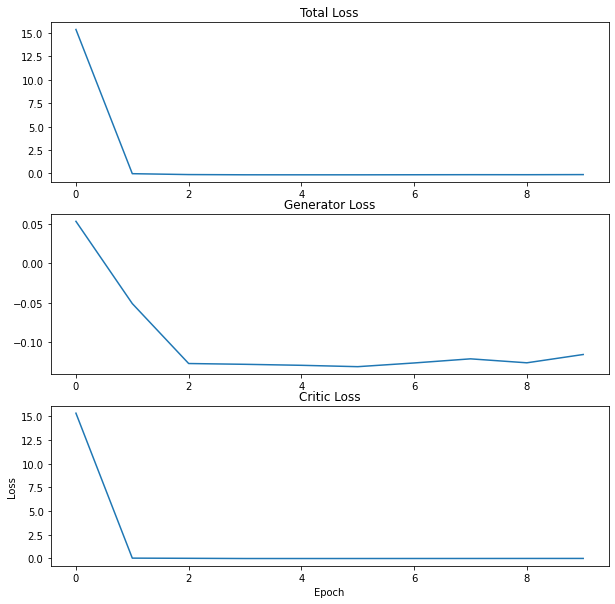

In [ ]:
########################################## TRAINING #########################################
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialise variables
epochs=10
lr=5e-4
interval=10
cuda=torch.cuda.is_available()
n_critic = 5
gp_lambda = 20

# Setup Adam optimizer for both
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
c_optimizer = optim.Adam(critic.parameters(), lr=lr)

# Initialise losses
total_loss = []
total_g_loss = []
total_c_loss = []

if cuda:
   generator = generator.cuda()
   critic = critic.cuda()
    
   print('G Parameters:', sum([p.numel() for p in generator.parameters() if p.requires_grad]))
   print('C Parameters:', sum([p.numel() for p in critic.parameters() if p.requires_grad]))
    
   best_loss = np.inf
    
   for epoch in range(1, epochs + 1):
     g_loss, c_loss = train_gan(epoch)
     loss = g_loss + c_loss
     total_loss.append(loss)
     total_g_loss.append(g_loss)
     total_c_loss.append(c_loss)
          
     if loss < best_loss:
        best_loss = loss
        print('* Saved')
        torch.save(generator.state_dict(), 'generator.th{}'.format(epoch))
        torch.save(critic.state_dict(), 'critic.th{}'.format(epoch))

     for i in range(10):
        joke = generate_joke(test_keywords[i].reshape(1, maxlen), generator.cpu(), stepper, decoder, tokenizer, start=[2])
        print(joke)

     generator = generator.cuda()
     print("")

# Plot results
fig, axs = plt.subplots(3)
fig.set_size_inches(10, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
axs[0].plot(range(epochs), total_loss)
axs[0].set_title('Total Loss')
axs[1].plot(range(epochs), total_g_loss)
axs[1].set_title('Generator Loss')
axs[2].plot(range(epochs), total_c_loss)
axs[2].set_title('Critic Loss')

G Parameters: 101000
C Parameters: 101000
Epoch: 1 | Batch: 0/100728 (0%) | G Loss: -0.107470 | C Loss: -0.007796
Epoch: 1 | Batch: 1280/100728 (1%) | G Loss: -0.134955 | C Loss: 0.132668
Epoch: 1 | Batch: 2560/100728 (3%) | G Loss: -0.143705 | C Loss: 0.026444
Epoch: 1 | Batch: 3840/100728 (4%) | G Loss: -0.149605 | C Loss: 0.041548
Epoch: 1 | Batch: 5120/100728 (5%) | G Loss: -0.153499 | C Loss: 0.017807
Epoch: 1 | Batch: 6400/100728 (6%) | G Loss: -0.155642 | C Loss: 0.017000
Epoch: 1 | Batch: 7680/100728 (8%) | G Loss: -0.152015 | C Loss: 0.019139
Epoch: 1 | Batch: 8960/100728 (9%) | G Loss: -0.143708 | C Loss: 0.018654
Epoch: 1 | Batch: 10240/100728 (10%) | G Loss: -0.130186 | C Loss: 0.013278
Epoch: 1 | Batch: 11520/100728 (11%) | G Loss: -0.109476 | C Loss: -0.001204
Epoch: 1 | Batch: 12800/100728 (13%) | G Loss: -0.086030 | C Loss: -0.012986
Epoch: 1 | Batch: 14080/100728 (14%) | G Loss: -0.069801 | C Loss: -0.023159
Epoch: 1 | Batch: 15360/100728 (15%) | G Loss: -0.061639 | C 

Text(0.5, 1.0, 'Critic Loss')

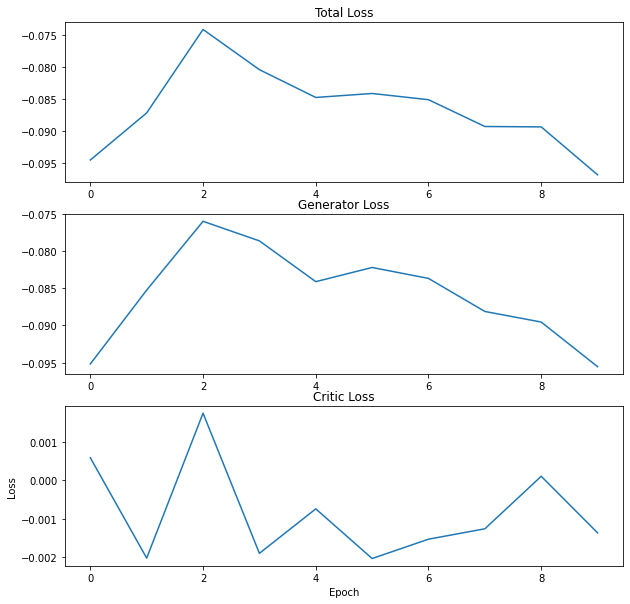

In [ ]:
########################################## FURTHER TRAINING #########################################
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialise variables
epochs=10
lr=5e-4
interval=10
cuda=torch.cuda.is_available()
n_critic = 5
gp_lambda = 20

# Setup Adam optimizer for both
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
c_optimizer = optim.Adam(critic.parameters(), lr=lr)

# Initialise losses
total_loss = []
total_g_loss = []
total_c_loss = []

if cuda:
   generator = generator.cuda()
   critic = critic.cuda()
    
   print('G Parameters:', sum([p.numel() for p in generator.parameters() if p.requires_grad]))
   print('C Parameters:', sum([p.numel() for p in critic.parameters() if p.requires_grad]))
    
   best_loss = np.inf
    
   for epoch in range(1, epochs + 1):
     g_loss, c_loss = train_gan(epoch)
     loss = g_loss + c_loss
     total_loss.append(loss)
     total_g_loss.append(g_loss)
     total_c_loss.append(c_loss)
          
     if loss < best_loss:
        best_loss = loss
        print('* Saved')
        torch.save(generator.state_dict(), 'generator.th{}'.format(epoch))
        torch.save(critic.state_dict(), 'critic.th{}'.format(epoch))

     for i in range(10):
        joke = generate_joke(test_keywords[i].reshape(1, maxlen), generator.cpu(), stepper, decoder, tokenizer, start=[2])
        print(joke)

     generator = generator.cuda()
     print("")

# Plot results
fig, axs = plt.subplots(3)
fig.set_size_inches(10, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
axs[0].plot(range(epochs), total_loss)
axs[0].set_title('Total Loss')
axs[1].plot(range(epochs), total_g_loss)
axs[1].set_title('Generator Loss')
axs[2].plot(range(epochs), total_c_loss)
axs[2].set_title('Critic Loss')

G Parameters: 101000
C Parameters: 101000
Epoch: 1 | Batch: 0/100728 (0%) | G Loss: -0.098262 | C Loss: -0.005887
Epoch: 1 | Batch: 1280/100728 (1%) | G Loss: -0.125849 | C Loss: 0.021238
Epoch: 1 | Batch: 2560/100728 (3%) | G Loss: -0.130697 | C Loss: 0.036274
Epoch: 1 | Batch: 3840/100728 (4%) | G Loss: -0.136659 | C Loss: 0.040123
Epoch: 1 | Batch: 5120/100728 (5%) | G Loss: -0.139472 | C Loss: 0.012610
Epoch: 1 | Batch: 6400/100728 (6%) | G Loss: -0.141312 | C Loss: 0.019171
Epoch: 1 | Batch: 7680/100728 (8%) | G Loss: -0.140416 | C Loss: 0.017550
Epoch: 1 | Batch: 8960/100728 (9%) | G Loss: -0.131221 | C Loss: 0.016304
Epoch: 1 | Batch: 10240/100728 (10%) | G Loss: -0.117167 | C Loss: 0.010969
Epoch: 1 | Batch: 11520/100728 (11%) | G Loss: -0.098082 | C Loss: -0.007990
Epoch: 1 | Batch: 12800/100728 (13%) | G Loss: -0.081545 | C Loss: -0.017212
Epoch: 1 | Batch: 14080/100728 (14%) | G Loss: -0.070950 | C Loss: -0.033520
Epoch: 1 | Batch: 15360/100728 (15%) | G Loss: -0.069949 | C 

Text(0.5, 1.0, 'Critic Loss')

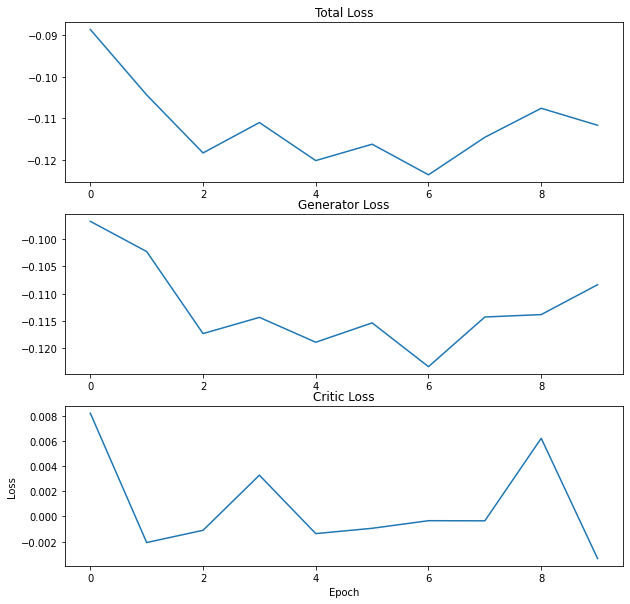

In [ ]:
########################################## EVEN FURTHER TRAINING #########################################
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialise variables
epochs=10
lr=5e-4
interval=10
cuda=torch.cuda.is_available()
n_critic = 5
gp_lambda = 20

# Setup Adam optimizer for both
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
c_optimizer = optim.Adam(critic.parameters(), lr=lr)

# Initialise losses
total_loss = []
total_g_loss = []
total_c_loss = []

if cuda:
   generator = generator.cuda()
   critic = critic.cuda()
    
   print('G Parameters:', sum([p.numel() for p in generator.parameters() if p.requires_grad]))
   print('C Parameters:', sum([p.numel() for p in critic.parameters() if p.requires_grad]))
    
   best_loss = np.inf
    
   for epoch in range(1, epochs + 1):
     g_loss, c_loss = train_gan(epoch)
     loss = g_loss + c_loss
     total_loss.append(loss)
     total_g_loss.append(g_loss)
     total_c_loss.append(c_loss)
          
     if loss < best_loss:
        best_loss = loss
        print('* Saved')
        torch.save(generator.state_dict(), 'generator.th{}'.format(epoch))
        torch.save(critic.state_dict(), 'critic.th{}'.format(epoch))

     for i in range(10):
        joke = generate_joke(test_keywords[i].reshape(1, maxlen), generator.cpu(), stepper, decoder, tokenizer, start=[2])
        print(joke)

     generator = generator.cuda()
     print("")

# Plot results
fig, axs = plt.subplots(3)
fig.set_size_inches(10, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
axs[0].plot(range(epochs), total_loss)
axs[0].set_title('Total Loss')
axs[1].plot(range(epochs), total_g_loss)
axs[1].set_title('Generator Loss')
axs[2].plot(range(epochs), total_c_loss)
axs[2].set_title('Critic Loss')

In [ ]:
torch.save(generator.state_dict(), 'generator.th')
torch.save(critic.state_dict(), 'critic.th')

In [ ]:
############################### CREATE MODELS AND LOAD WEIGHTS ############################
n_layers = 5
block_dim = 100

# Create model and load weights
generator = Generator(n_layers, block_dim)
generator.eval()
generator.load_state_dict(torch.load('/content/generator.th', map_location='cpu'))
model, encoder, stepper, decoder = r_seq2seq(weights='/content/reconstruction_weights.h5')

In [ ]:
for i in range(100):
  input = test_seq[i]
  kw = test_keywords[i]
  true = detokenize(input, tokenizer)
  kw2 = detokenize(kw, tokenizer)
  print("KEYWORDS:", ' '.join([x for x in kw2 if x != '[PAD]' and x != '[START]']))
  print("TRUE:", ' '.join([x for x in true if x != '[PAD]' and x != '[START]']))
  joke = generate_joke(kw.reshape(1, maxlen),generator.cpu(), stepper, decoder, tokenizer, start=[2])
  print('GENERATED',joke)
  print("")

KEYWORDS: switch light arguing
TRUE: how do you end two deaf persons ' arguing ? switch off the light .
GENERATED  how can you switch as fadinburgach ness are like bbq style from the light ? a switch .

KEYWORDS: suckin lot lose hurricane house first common blowin blonde
TRUE: what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .
GENERATED  the ukraine if you are with the rain moth ? it ? ? ? ? ? a rain moth blue and then

KEYWORDS: went floats day circles
TRUE: i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .
GENERATED  wanna rich on the other day they went on one side of the other day they

KEYWORDS: would neighbor joke home close
TRUE: i would make a joke about my neighbor . but it would be too close to home
GENERATED  did you think his neighbor loves to be his swedishpical cycle like you are always in south east swedish

KEYWORDS: god everythin

# Evaluation

In [ ]:
# Load Gan
n_layers = 5
block_dim = 100

# Create model and load weights for GAN
generator = Generator(n_layers, block_dim)
generator.eval()
generator.load_state_dict(torch.load('/content/generator.th', map_location='cpu'))
model, encoder, stepper, decoder = r_seq2seq(weights='/content/reconstruction_weights.h5')

# Load VAE
vae_enc, vae_dec = vae(weights_e='/content/vae_enc_weights.h5', 
                weights_d='/content/vae_dec_weights.h5')

# Load Seq2Seq
s2s_enc, s2s_dec = seq2seq(weights='/content/seq2seq_weights.h5')

In [ ]:
# Test With Some Samples
gan_out = []
vae_out = []
s2s_out = []
correct = []
kw_list = []

for i in range(len(test_seq)):
  input = test_seq[i]
  kw = test_keywords[i]
  true = detokenize(input, tokenizer)
  true = ' '.join([x for x in true if x != '[PAD]' and x != '[START]'])
  kw2 = detokenize(kw, tokenizer)
  kw2 = ' '.join([x for x in kw2 if x != '[PAD]' and x != '[START]'])
  print("KEYWORDS:", kw2)
  print("TRUE:", true)
  gan = generate_joke(kw.reshape(1, maxlen),generator.cpu(), stepper, decoder, tokenizer)
  vae = decoder_decode(kw.reshape(1, maxlen), vae_enc, vae_dec, tokenizer)
  s2s = decoder_decode(kw.reshape(1, maxlen), s2s_enc, s2s_dec, tokenizer)
  print('GAN:',gan)
  print('VAE:',vae)
  print('S2S:',s2s)
  gan_out.append(gan)
  vae_out.append(vae)
  s2s_out.append(s2s)
  correct.append(true)
  kw_list.append(kw2)
  print("")

KEYWORDS: switch light arguing
TRUE: how do you end two deaf persons ' arguing ? switch off the light .
GAN:  the ambulance has onefullyy so you can switche by one direction this one fleb
VAE:  if arguing with a switch , 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 000
S2S:  two people are arguing with a light bulb . just won ' t switch off the switch .

KEYWORDS: suckin lot lose hurricane house first common blowin blonde
TRUE: what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .
GAN:  howyou can sidesin when the 2016 presidential election has been the first state cin brin b .
VAE:  what does a hurricane and a hurricane have in common ? they both suck at first , they both suck .
S2S:  what do a blonde and a lot have in common ? they both both moan at the house .

KEYWORDS: went floats day circles
TRUE: i went to a white pride parade the other day . the floats just kept going around in circles about 200 mil

In [ ]:
# Create and save dataframe of results
import pandas as pd

data = {'Input Keywords':kw_list, 
        'Original Output':correct, 
        'Seq2Seq':s2s_out, 
        'VAE':vae_out, 
        'GAN':gan_out}

df = pd.DataFrame(data)
df.to_csv('results.csv')
df.head(20)

,Input Keywords,Original Output,Seq2Seq,VAE,GAN
0,switch light arguing,how do you end two deaf persons ' arguing ? sw...,two people are arguing with a light bulb . ju...,"if arguing with a switch , 0000 0000 0000 000...",the ambulance has onefullyy so you can switch...
1,suckin lot lose hurricane house first common b...,what does a blonde have in common with a hurri...,what do a blonde and a lot have in common ? t...,what does a hurricane and a hurricane have in...,howyou can sidesin when the 2016 presidential...
2,went floats day circles,i went to a white pride parade the other day ....,i went to the round of the other day i went r...,i went to the other day and a day keeps going...,has you wanna hear 11 drivers ? it went the d...
3,would neighbor joke home close,i would make a joke about my neighbor . but it...,i would tell a joke about my neighbor is door...,why is the best part about being a joke ? bec...,blondes are confusing till what they are expe...
4,god everything difference,what is the difference between god and you ex ...,what is the difference between god and god ? ...,what is the difference between god and god ? ...,why did kenk shout in chukh bukh buk
5,swear castrate,"i swear , i will castrate you do it , you won ...",i swear my actors i have a castrate bridge . ...,what is the easiest way to castrate a boat ? ...,has you can t cast rich content with tristary...
6,woman way tits looking eyes checks,the first thing a man notices about a woman is...,i ' m looking for a woman with her tits . she...,i ' m looking for a woman with no eyes i ' m ...,did you want through the eyes ? because it wa...
7,get dead,what is your favourite insult joke ? i will ge...,what do you get when you cross a dead dead mu...,why do you get a pterodactyl laugh ? because ...,can t eat it for eyes but it is the dead tast...
8,way thought mall harsh,trump hows that mexican mall going ? mall ? we...,i thought that was the same way to be a mall ...,why did the blonde fail algebra ? because she...,wanna hear michael jordan strip compliments s...
9,anyone,keanu reeves donates so much blood that anyone...,anyone who is a lot like a new year old ? any...,anyone who is the best part about anyone ? an...,"you can land with jeff 198 , man ? jeffher da..."


In [ ]:
# UNIQUE TOKENS
import pandas as pd
from collections import Counter
from nltk import ngrams

df = pd.read_csv('/content/results.csv')
s2s = " ".join(list(df['Seq2Seq'])).split(" ")
vae = " ".join(list(df['VAE'])).split(" ")
gan = ' '.join(str(v) for v in df['GAN']).split(" ")
original = ' '.join(str(v) for v in df['Original Output']).split(" ")

print('UNIQUE TOKENS')
print('S2S:', len(set(s2s)))
print('VAE:', len(set(vae)))
print('GAN:', len(set(gan)))
print('TRUE:', len(set(original)))
print("")

print('UNIQUE BIGRAMS')
print('S2S:', len(Counter(ngrams(s2s,2))))
print('VAE:', len(Counter(ngrams(vae,2))))
print('GAN:', len(Counter(ngrams(gan,2))))
print('TRUE:', len(Counter(ngrams(original,2))))
print("")

print('UNIQUE TRIGRAMS')
print('S2S:', len(Counter(ngrams(s2s,3))))
print('VAE:', len(Counter(ngrams(vae,3))))
print('GAN:', len(Counter(ngrams(gan,3))))
print('TRUE:', len(Counter(ngrams(original,3))))
print("")

print('UNIQUE QUADGRAMS')
print('S2S:', len(Counter(ngrams(s2s,4))))
print('VAE:', len(Counter(ngrams(vae,4))))
print('GAN:', len(Counter(ngrams(gan,4))))
print('TRUE:', len(Counter(ngrams(original,4))))
print('')

print('UNIQUE PENTGRAMS')
print('S2S:', len(Counter(ngrams(s2s,5))))
print('VAE:', len(Counter(ngrams(vae,5))))
print('GAN:', len(Counter(ngrams(gan,5))))
print('TRUE:', len(Counter(ngrams(original,5))))

In [ ]:
# Explore frequent phrases of outputs
from collections import Counter
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns

s2s = " ".join(list(df['Seq2Seq'])).split(" ")
vae = " ".join(list(df['VAE'])).split(" ")
gan = ' '.join(str(v) for v in df['GAN']).split(" ")
original = ' '.join(str(v) for v in df['Original Output']).split(" ")

s2s = Counter(ngrams(s2s,5))
vae = Counter(ngrams(vae,5))
gan = Counter(ngrams(gan,5))
original = Counter(ngrams(original,5))

# Create data frames for the frequencies
#unigrams = pd.DataFrame(unigrams.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
s2s = pd.DataFrame(s2s.items(),columns=['S2S','frequency']).sort_values(by='frequency',ascending=False)
vae = pd.DataFrame(vae.items(),columns=['VAE','frequency']).sort_values(by='frequency',ascending=False)
gan = pd.DataFrame(gan.items(),columns=['GAN','frequency']).sort_values(by='frequency',ascending=False)
original = pd.DataFrame(original.items(),columns=['Human','frequency']).sort_values(by='frequency',ascending=False)

# create subplot of the different data frames
fig, axes = plt.subplots(4,1,figsize=(10,10))
sns.barplot(ax=axes[0],x='frequency',y='Human',data=original.head(10), color='green')
sns.barplot(ax=axes[1],x='frequency',y='GAN',data=gan.head(10), color='yellow')
sns.barplot(ax=axes[2],x='frequency',y='S2S',data=s2s.head(10), color='blue')
sns.barplot(ax=axes[3],x='frequency',y='VAE',data=vae.head(10), color='red')

In [ ]:
s2s = " ".join(list(df['Seq2Seq'])).split(" ")
vae = " ".join(list(df['VAE'])).split(" ")
gan = ' '.join(str(v) for v in df['GAN']).split(" ")
original = ' '.join(str(v) for v in df['Original Output']).split(" ")


s2s = Counter(ngrams(s2s,2))
vae = Counter(ngrams(vae,2))
gan = Counter(ngrams(gan,2))
original = Counter(ngrams(correct,2))

s2s = pd.DataFrame(s2s.items(),columns=['S2S','frequency']).sort_values(by='frequency',ascending=False)
vae = pd.DataFrame(vae.items(),columns=['VAE','frequency']).sort_values(by='frequency',ascending=False)
gan = pd.DataFrame(gan.items(),columns=['GAN','frequency']).sort_values(by='frequency',ascending=False)
original = pd.DataFrame(original.items(),columns=['Human','frequency']).sort_values(by='frequency',ascending=False)

print("Human")
print(original.describe())
print(" ")

print("GAN")
print(gan.describe())
print(" ")

print("VAE")
print(vae.describe())
print(" ")

print("S2S")
print(s2s.describe())

In [ ]:
# BLEU
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method4

# Drop rows with empty values
dropped = df.dropna()

original = [x.split(" ") for x in dropped['Original Output']]
s2s_can = [x.split(" ") for x in dropped['Seq2Seq']]
vae_can = [x.split(" ") for x in dropped['VAE']]
gan_can = [x.split(" ") for x in dropped['GAN']]

# Calculate and print BLEU
print('BLEU')
print('s2s:', corpus_bleu(original, s2s_can, smoothing_function=smoothie, auto_reweigh=True)*100)
print('vae:', corpus_bleu(original, vae_can, smoothing_function=smoothie, auto_reweigh=True)*100)
print('gan:', corpus_bleu(original, gan_can, smoothing_function=smoothie, auto_reweigh=True)*100)

BLEU
s2s: 3.8955895683019466
vae: 2.833437267610083
gan: 2.4717752741397305


In [ ]:
# BERTSCORE
from datasets import load_metric
bertscore = load_metric("bertscore")

original = dropped['Original Output']
s2s_can = dropped['Seq2Seq']
vae_can = dropped['VAE']
gan_can = dropped['GAN']

s2s_score = bertscore.compute(predictions=s2s_can, references=original, lang="en")
vae_score = bertscore.compute(predictions=vae_can, references=original, lang="en")
gan_score = bertscore.compute(predictions=gan_can, references=original, lang="en")

# Calculate and print BLEU
print('BERTSCORE')
print('s2s precision:', sum(s2s_score['precision'])/len(dropped)*100)
print('s2s recall:', sum(s2s_score['recall'])/len(dropped)*100)
print('s2s f1:', sum(s2s_score['f1'])/len(dropped)*100)
print(" ")

print('vae precision:', sum(vae_score['precision'])/len(dropped)*100)
print('vae recall:', sum(vae_score['recall'])/len(dropped)*100)
print('vae f1:', sum(vae_score['f1'])/len(dropped)*100)
print(" ")

print('gan precision:', sum(gan_score['precision'])/len(dropped)*100)
print('gan recall:', sum(gan_score['recall'])/len(dropped)*100)
print('gan f1:', sum(gan_score['f1'])/len(dropped)*100)

In [ ]:
# SUMMARISE HUMAN EVALUATION
import pandas as pd

# 1= Not Funny, 5=Funny
ratings = pd.read_csv('/content/Rate Jokes (Responses) - Form Responses 1.csv')
ratings.head(30)

,Timestamp,I would make a joke about my neighbor. But it would be too close to home,Blondes are confusing till what they are expensive till they are the best edest ride they are close at home.,"Why is the best part about being a joke? because if it would be home, I can close it home.",I would tell a joke about my neighbor is door. I would be a close to the home.,When Is a door not a door? when it is ajar .,How do repnolds smell like your door? It is heading inside your door.,When is a door not a door ? It is ajar .,When is a door's favorite kind of door? When it is ajar.,What brand microphone did Kurt Cobain use? remingtoni head the feedback was hell.,How hell can't you feed golden movies decoration? because they are only fake ants.,What is the best part about a gay man? a large dog.,Feeds and feeds. Feed the hell outback .,What do you call an immigrant fighting a rapist? alien vs predator,Why do you really hate? Because he has a perfanoxious as the magical machine. Predator coat,What do you call a rapist that gets into a rapist? alien vs predator,What do you call a rapist with a rapist ? alien vs predator,I gave away all of my dead batteries free of charge .,How do you throw 1000 as a careries on particular car? Juan on charge.,Why did the electrons go to charge? because electrons was resisting a charge,Why did the neutron receive a nipple pierced? because of charge.
0,7/31/2021 17:43:51,3,3,4,4,3,3,4,4,4,4,3,4,3,4,3,3,4,4,4,4
1,7/31/2021 17:45:41,1,1,1,1,2,2,2,2,2,2,3,2,4,1,3,3,4,4,5,5
2,7/31/2021 17:47:49,3,3,3,4,2,3,4,4,3,5,3,3,3,1,2,3,4,4,3,3
3,7/31/2021 17:51:08,4,1,1,1,4,1,1,1,1,1,1,1,4,1,1,1,3,1,1,1
4,7/31/2021 17:52:51,3,1,1,1,4,2,4,1,2,1,1,1,2,1,1,1,4,1,2,2
5,7/31/2021 17:55:50,5,3,3,3,5,4,4,1,3,2,1,4,3,5,5,5,5,3,5,5
6,7/31/2021 18:10:59,3,2,4,4,5,3,5,1,3,4,4,4,5,4,3,4,5,4,5,3
7,7/31/2021 18:15:16,4,3,2,4,2,3,3,4,2,2,3,2,1,1,2,3,4,1,4,4
8,7/31/2021 18:15:32,3,1,2,2,3,1,3,3,3,4,5,3,5,2,3,2,4,4,3,3
9,7/31/2021 18:15:57,1,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,4,1,1,1


In [ ]:
# Extract the jokes into their respective categories
original_r = []
gan_r = []
vae_r = []
s2s_r = []

for i in range(1,21,4):
  original_r += list(ratings.iloc[:,i])
  gan_r += list(ratings.iloc[:,i+1])
  vae_r += list(ratings.iloc[:,i+2])
  s2s_r += list(ratings.iloc[:,i+3])

In [ ]:
# Average Ratings
print('Average Original Rating:', sum(original_r)/140)
print('Average GAN Rating:', sum(gan_r)/140)
print('Average VAE Rating:', sum(vae_r)/140)
print('Average S2S Rating:', sum(s2s_r)/140)

Average Original Rating: 3.45
Average GAN Rating: 2.6142857142857143
Average VAE Rating: 2.8857142857142857
Average S2S Rating: 2.7214285714285715


In [ ]:
# Standard deviation of ratings
print("Original STD:", np.std(original_r))
print("GAN STD:", np.std(gan_r))
print("VAE STD:", np.std(vae_r))
print("S2S STD:", np.std(s2s_r))

Original STD: 1.2723712396264588
GAN STD: 1.401966548845454
VAE STD: 1.4045116807006235
S2S STD: 1.429624611781794


In [ ]:
# Check the rate at which synthethic jokes rank better than the original ones.
gan_b = 0
vae_b = 0
s2s_b = 0

for i in range(len(original_r)):
  if gan_r[i] >= original_r[i]:
    gan_b += 1

  if vae_r[i] >= original_r[i]:
    vae_b += 1

  if s2s_r[i] >= original_r[i]:
    s2s_b += 1

print("RATE AT WHICH SYNTHETIC JOKES >= HUMAN CURATED")
print("GAN:", gan_b/len(original_r)*100)
print("VAE:", vae_b/len(original_r)*100)
print("S2S:", s2s_b/len(original_r)*100)

RATE AT WHICH SYNTHETIC JOKES >= HUMAN CURATED
GAN: 46.42857142857143
VAE: 56.42857142857143
S2S: 50.71428571428571


# Free hand test (Run)

In [ ]:
##################################### LOAD MODELS #######################################
n_layers = 5
block_dim = 100

# Create model and load weights for GAN
generator = Generator(n_layers, block_dim)
generator.eval()
generator.load_state_dict(torch.load('/content/generator.th', map_location='cpu'))
model, encoder, stepper, decoder = r_seq2seq(weights='/content/reconstruction_weights.h5')

# Load VAE
vae_enc, vae_dec = vae(weights_e='/content/vae_enc_weights.h5', 
                weights_d='/content/vae_dec_weights.h5')

# Load Seq2Seq
s2s_enc, s2s_dec = seq2seq(weights='/content/seq2seq_weights.h5')

In [ ]:
############################### FREE HAND TEST INTERFACE ################################
import numpy as np
import keras
import tensorflow as tf

prompt = "play sleep"
tokens = tokenizer.tokenize(prompt)
tokens = tf.squeeze(tokens,axis=0)
tokens = list(tf.squeeze(tokens, axis=1).numpy())
kw = keras.preprocessing.sequence.pad_sequences([tokens], value=0, padding='post', maxlen=maxlen)[0]
kw = kw.reshape(1, maxlen)

gan = generate_joke(kw,generator.cpu(), stepper, decoder, tokenizer)
vae = decoder_decode(kw, vae_enc, vae_dec, tokenizer, top_k=2)
s2s = decoder_decode(kw, s2s_enc, s2s_dec, tokenizer, top_k=2)
print('KEYWORDS:', prompt)
print('GAN:',gan)
print('VAE:',vae)
print('S2S:',s2s)

KEYWORDS: play sleep
GAN:  why does ireland fall through the toilet seat ? they are not a play by the blavs
VAE:  what do you call a play in a sleep ? a good time
S2S:  why did the mexican train get to sleep with his sleep ? he couldn t like to get it to sleep .


In [ ]:
prompt = "goat"
tokens = tokenizer.tokenize(prompt)
tokens = tf.squeeze(tokens,axis=0)
tokens = list(tf.squeeze(tokens, axis=1).numpy())
kw = keras.preprocessing.sequence.pad_sequences([tokens], value=0, padding='post', maxlen=maxlen)[0]
kw = kw.reshape(1, maxlen)

gan = generate_joke(kw,generator.cpu(), stepper, decoder, tokenizer)
vae = decoder_decode(kw, vae_enc, vae_dec, tokenizer, top_k=2)
s2s = decoder_decode(kw, s2s_enc, s2s_dec, tokenizer, top_k=2)
print('KEYWORDS:', prompt)
print('GAN:',gan)
print('VAE:',vae)
print('S2S:',s2s)

KEYWORDS: goat
GAN:  what do you call tomato as kleasoy blub cream ? bukak
VAE:  what did the muslim say when his goat is ? he is a goat .
S2S:  what is the smallest goat is favorite organ ? the goat .


In [ ]:
prompt = "fat mother"
tokens = tokenizer.tokenize(prompt)
tokens = tf.squeeze(tokens,axis=0)
tokens = list(tf.squeeze(tokens, axis=1).numpy())
kw = keras.preprocessing.sequence.pad_sequences([tokens], value=0, padding='post', maxlen=maxlen)[0]
kw = kw.reshape(1, maxlen)

gan = generate_joke(kw,generator.cpu(), stepper, decoder, tokenizer)
vae = decoder_decode(kw, vae_enc, vae_dec, tokenizer, top_k=2)
s2s = decoder_decode(kw, s2s_enc, s2s_dec, tokenizer, top_k=2)
print('KEYWORDS:', prompt)
print('GAN:',gan)
print('VAE:',vae)
print('S2S:',s2s)

KEYWORDS: fat mother
GAN:  why do you moon has been fat when he does rainy always float ? a blunderman .
VAE:  what is your best part about being fat ? your mother
S2S:  yo mama so fat she has been fat she has been fat .


In [ ]:
prompt = "tequila shots"
tokens = tokenizer.tokenize(prompt)
tokens = tf.squeeze(tokens,axis=0)
tokens = list(tf.squeeze(tokens, axis=1).numpy())
kw = keras.preprocessing.sequence.pad_sequences([tokens], value=0, padding='post', maxlen=maxlen)[0]
kw = kw.reshape(1, maxlen)

gan = generate_joke(kw,generator.cpu(), stepper, decoder, tokenizer)
vae = decoder_decode(kw, vae_enc, vae_dec, tokenizer, top_k=1)
s2s = decoder_decode(kw, s2s_enc, s2s_dec, tokenizer, top_k=1)
print('KEYWORDS:', prompt)
print('GAN:',gan)
print('VAE:',vae)
print('S2S:',s2s)

KEYWORDS: tequila shots
GAN:  wanna know why the male husbands rushed to get away ? because they are ed outside your shots .
VAE:  why is tequila tequila not tequila ? tequila mockingbird
S2S:  why did the mexican man get his shots ? tequila


In [ ]:
prompt = "dancing clown"
tokens = tokenizer.tokenize(prompt)
tokens = tf.squeeze(tokens,axis=0)
tokens = list(tf.squeeze(tokens, axis=1).numpy())
kw = keras.preprocessing.sequence.pad_sequences([tokens], value=0, padding='post', maxlen=maxlen)[0]
kw = kw.reshape(1, maxlen)

gan = generate_joke(kw,generator.cpu(), stepper, decoder, tokenizer)
vae = decoder_decode(kw, vae_enc, vae_dec, tokenizer, top_k=1)
s2s = decoder_decode(kw, s2s_enc, s2s_dec, tokenizer, top_k=1)
print('Keywords:', prompt)
print('GAN:',gan)
print('VAE:',vae)
print('S2S:',s2s)

KEYWORDS: dancing clown
GAN:  how should they get the worst period of it ? crimea river
VAE:  why do you never trust old people at the slaughter ? they are dancing .
S2S:  why do sharksters eat a clown ? because it might lead while dancing .


In [ ]:
prompt = "clown president"
tokens = tokenizer.tokenize(prompt)
tokens = tf.squeeze(tokens,axis=0)
tokens = list(tf.squeeze(tokens, axis=1).numpy())
kw = keras.preprocessing.sequence.pad_sequences([tokens], value=0, padding='post', maxlen=maxlen)[0]
kw = kw.reshape(1, maxlen)

gan = generate_joke(kw,generator.cpu(), stepper, decoder, tokenizer)
vae = decoder_decode(kw, vae_enc, vae_dec, tokenizer, top_k=1)
s2s = decoder_decode(kw, s2s_enc, s2s_dec, tokenizer, top_k=1)
print('Keywords:', prompt)
print('GAN:',gan)
print('VAE:',vae)
print('S2S:',s2s)